In [1]:
%pylab inline
import numpy as np
import galsim
from lsst.sims.photUtils import BandpassDict, Sed
import lsst.sims.skybrightness as skybrightness
import lsst.sims.coordUtils
import lsst.sims.photUtils.PhotometricParameters as phopara

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Original code in https://github.com/LSSTDESC/imSim/blob/master/python/desc/imsim/skyModel.py
def sky_counts_per_sec(skyModel, photParams, bandpass, magNorm=None):
    """
    Compute the sky background counts per pixel per second.  Note that
    the gain in photParams is applied to the return value such that
    "counts" are in units of ADU.
    Parameters
    ----------
    skyModel: lsst.sims.skybrightness.SkyModel
        Model of the sky for the current epoch.
    photParams: lsst.sims.photUtils.PhotometricParameters
        Object containing parameters of the photometric response of the
        telescope, including pixel scale, gain, effective area, exposure
        time, number of exposures, etc.
    bandpass: lsst.sims.photUtils.Bandpass
        Instrumental throughput for a particular passband.
    magNorm: float [None]
        If not None, then renormalize the sky SED to have a monochromatic
        magnitude of magNorm at 500nm.  Otherwise, use the default
        skyModel normalization.
    Returns
    -------
    ADUs per second per pixel
    """
    wave, spec = skyModel.returnWaveSpec()
    sed = Sed(wavelen=wave, flambda=spec[0, :])
    if magNorm is not None:
        flux_norm = sed.calcFluxNorm(magNorm, bandpass)
        sed.multiplyFluxNorm(flux_norm)
    countrate_per_arcsec = sed.calcADU(bandpass=bandpass, photParams=photParams)
    exptime = photParams.nexp*photParams.exptime
    return countrate_per_arcsec*photParams.platescale**2/exptime


# function to plot each component of the image
def plot_component (Fringing_sim,UpperAtm,Skybg,stack):
    plt.figure(figsize = (20,4))
    plt.subplot(143)
    plt.title('UpperAtm')
    plt.imshow(UpperAtm.array,cmap = 'gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(144)
    plt.title('Sky background')
    plt.imshow(Skybg.array,cmap = 'gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(142)
    plt.title('Fringing sim')
    plt.imshow(Fringing_sim,cmap = 'gray')
    plt.colorbar()
    plt.axis('off')
    plt.subplot(141)
    plt.title('Stacked Image')
    plt.imshow(stack,cmap = 'gray')
    plt.colorbar()
    plt.axis('off') 

Initialize the following modelling parameters:
- Photometric parameters
- Bandpass 
- SkyModel


In [3]:
# Initialize Photometric parameters
photParams = phopara(bandpass='y')
# Calculate exposure time
exposureTime = photParams.nexp*photParams.exptime

# Initialize Bandpass
bandpassdict = BandpassDict.loadBandpassesFromFiles()[0]
bandpass = bandpassdict['y']

# Instatiate the sky model
compList = ['scatteredStar','lowerAtm','upperAtm','airglow','mergedSpec','twilight',
           'zodiacal','moon']

sm = skybrightness.SkyModel(lowerAtm=True, upperAtm=True,airglow=True, scatteredStar=True,mergedSpec=False)

# Set Ra Dec and Mjd, can change later
sm.setRaDecMjd(5.497787143782138,-1.5197597516422303,49353.177645)

Generate two seperate sky spectrum: One for sky background, one for upper atmosphere (Mostly OH emission lines) \
And then calculate counts for the two spectrum using sky_counts_per_sec

In [4]:
# sky bg spectrum
for comp in compList: setattr(sm, comp, True)
# Turn off upperAtm
sm.mergedSpec= False
sm.upperAtm = False
# Compute the spectra
sm._interpSky()
CountSkyBg = sky_counts_per_sec(skyModel=sm,photParams=photParams,bandpass=bandpass)

In [5]:
# Upper Atm spectrum
for comp in compList: setattr(sm, comp, False)
sm.mergedSpec= False
# Turn on upper atm
sm.upperAtm = True
# Compute the spectra
sm._interpSky()
CountUpperAtm = sky_counts_per_sec(skyModel=sm,photParams=photParams,bandpass=bandpass)

Adding noise to the two sky backgrounds

In [6]:
# Adding noise to sky background
randomNum = galsim.UniformDeviate()
noise = galsim.CCDNoise(randomNum,sky_level=0.0,gain=photParams.gain,read_noise=photParams.readnoise)

# Making a galsim image for sky bg & upper Atm
image_Skybg = np.ones(shape = (3974,4000))*CountSkyBg*exposureTime
galsim_image_Skybg = galsim.Image(image_Skybg, copy=True)

image_UpperAtm = np.ones(shape = (3974,4000))*CountUpperAtm*exposureTime
galsim_image_UpperAtm = galsim.Image(image_UpperAtm, copy=True)

# Adding noise to images
galsim_image_Skybg.addNoise(noise)
galsim_image_UpperAtm.addNoise(noise)

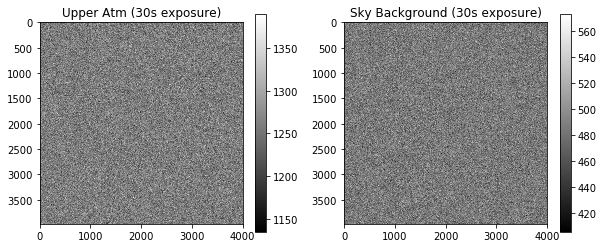

In [7]:
f,ax = plt.subplots(ncols=2,figsize =(10,4))
im1 = ax[0].imshow(galsim_image_UpperAtm.array,cmap='gray')
ax[0].set_title('Upper Atm (%is exposure)'%exposureTime)
im2 = ax[1].imshow(galsim_image_Skybg.array,cmap='gray')
ax[1].set_title('Sky Background (%is exposure)'%exposureTime)
f.colorbar(im1,ax=ax[0])
f.colorbar(im2,ax=ax[1]);

Run fringing simulation based on UpperAtm background

In [8]:
import astropy.units as u
from Getindex import load_refraction_data
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 183.)
import TMMSIM
from numba import jit
from tqdm import tqdm
from astropy.io import fits
import pickle
from scipy import interpolate
import bandpass

In [9]:
# Load interpolator
dbfile = open('data/Interpolator.pkl', 'rb')  
interpolator = pickle.load(dbfile)
dbfile.close()


dbfile = open('data/Mono_interpolator.pkl', 'rb')  
interpolators = pickle.load(dbfile)
dbfile.close()


# sky line files from Robert
file = 'data/skyLines.txt'
wavelength = np.loadtxt(file,usecols=[0])
intensity = np.loadtxt(file,usecols=[1])
#group = np.loadtxt(file,usecols=[4])

# LSST y filter throughput
y_filter = 'data/throughputs/baseline/total_y.dat'
yband_wlen = np.round(np.loadtxt(y_filter,usecols=[0]),1)
yband_throughput = np.loadtxt(y_filter,usecols=[1])

In [10]:
# Apply LSST bandpass to OH lines and assign proper weight to each line
wavelength_mask,line_weight,intensity_filter,spec = bandpass.conv(wlen_min=900,wlen_max=1100)

line_intensity = line_weight[intensity_filter]/np.sum(line_weight[intensity_filter])

wavelengths = np.round(wavelength[wavelength_mask][intensity_filter],1)

In [11]:
# Load the height map of Epoxy layer of a particular E2V sensor
hh = fits.open('data/E2V-321.fits')
MAP = hh[1].data['sim']
MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)

# Find the unique array from height map and indices of the unique array that reconstructs the origin array
uu, indices = np.unique(MAP,return_inverse=True)

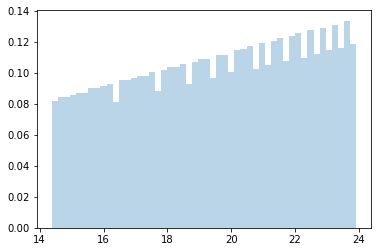

In [12]:
# Incident angle distribution and corresponding weight
angles,weight = bandpass.get_angle(theta_x=0,theta_y=0);

First, to make sure the code runs as expected, just run sim for a single line

In [13]:
# Create array that stores sim results
sim_res = np.zeros(shape = Fitting.shape)

# Load the interpolator for that specific line
int_f = interpolator['969.3']

# Get absorption probability for each value in the unique array based on incident angle using the interpolator
ss = int_f(uu,angles)

# Weighted sum over incident angles
total = np.sum(ss.T * weight, axis = 1)

# Reconstruct fringing pattern array so that it has the same shape as the thickness map
final = total[indices]
sim_res += final.reshape(3974,4000)

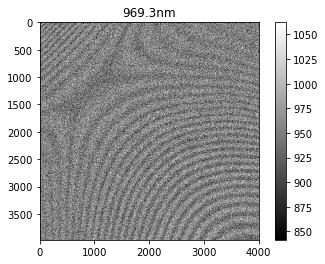

In [14]:
total = sim_res*galsim_image_UpperAtm.array + galsim_image_Skybg.array
plt.imshow(total,cmap = 'gray')
plt.colorbar()
plt.title('969.3nm');

Looks good. Next, run sim for all OH lines and stack them properly

In [15]:
sim_res = np.zeros(shape = Fitting.shape)
for wlen,wgt in zip(wavelengths,line_intensity):
    int_f = interpolator[str(wlen)]
    ss = int_f(uu,angles)
    sst = ss.T
    total = np.sum(sst * weight, axis = 1)
    final = total[indices]
    sim_res += wgt*final.reshape(3974,4000)

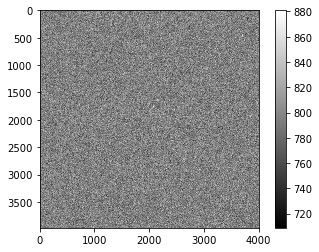

In [16]:
total = sim_res*galsim_image_UpperAtm.array + galsim_image_Skybg.array
plt.imshow(total,cmap = 'gray')
plt.colorbar()

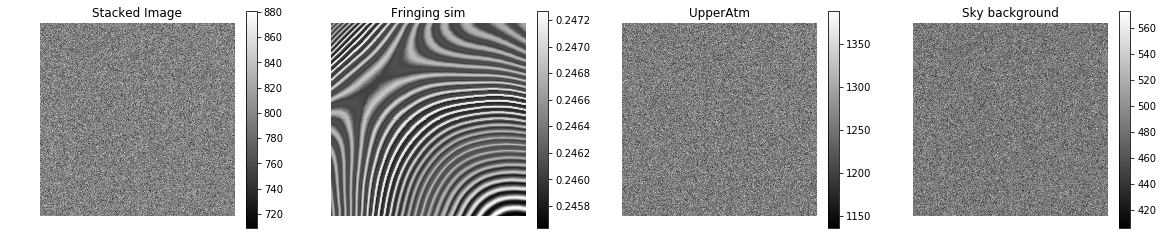

In [17]:
# look at each component seperately
plot_component(sim_res,galsim_image_UpperAtm,galsim_image_Skybg,total)

Run sim again, but with the set up of MonoCam

In [18]:
# MonoCam incident angle range
th_min=0.1*u.deg 
th_max=7.13*u.deg
angles = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
weight = angles / np.sum(angles)

In [19]:
# Run with interpolator for MonoCam 
sim_res_mono = np.zeros(shape = Fitting.shape)
for wlen,wgt in zip(wavelengths,line_intensity):
    int_f = interpolators[str(wlen)]
    ss = int_f(uu,angles)
    sst = ss.T
    total = np.sum(sst * weight, axis = 1)
    final = total[indices]
    sim_res_mono += wgt*final.reshape(3974,4000)

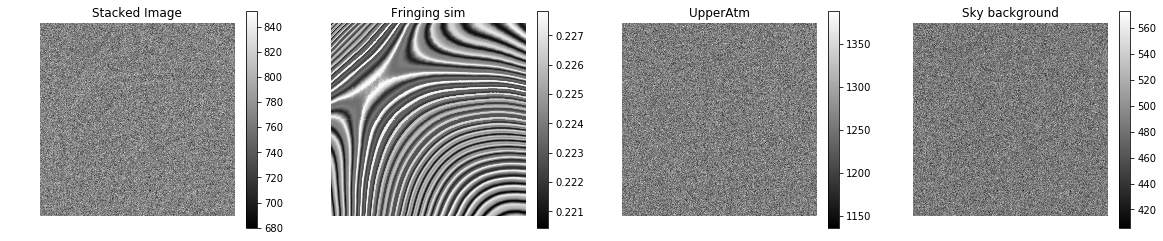

In [20]:
total = sim_res_mono*galsim_image_UpperAtm.array + galsim_image_Skybg.array
plot_component(sim_res_mono,galsim_image_UpperAtm,galsim_image_Skybg,total)